<h1 style="text-align: center;">A Tutorial for (Probabilistic) Bayesian Neural Networks</h1>
<p style="text-align: center;"> A short version of <a href="https://keras.io/examples/keras_recipes/bayesian_neural_networks/">Khalid Salama's blog post</a> with Son Hai Le's modifications </p>

**Goal of this document**
- Implementation of standard neural network ([SNN](http://www.deeplearningbook.org))
- Implementation of 2 types of Bayesian neural network ([BNN](https://ieeexplore.ieee.org/document/9756596)):
    * BNN: deal with [epistemic uncertainty](https://www.sciencedirect.com/science/article/abs/pii/S0167473008000556)
    * Probabilistic BNN: deal with both [aleatoric uncertainty](https://www.sciencedirect.com/science/article/abs/pii/S0167473008000556) and [epistemic uncertainty](https://www.sciencedirect.com/science/article/abs/pii/S0167473008000556)


**What are different compared to the original** [Khalid Salama's blog post](https://keras.io/examples/keras_recipes/bayesian_neural_networks)?
- Make the document more succinct, remove unnecessary theory parts
- Add an [exploratory data analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis)
- Add codes to save and load the weights of the model
- Add visualization of the predictions

*Note: follow [hyperlinks]() to see more details*

## Python packages
 - [TensorFlow](https://www.tensorflow.org/) 2.3 or higher: for neural networks
 - [TensorFlow Probability](https://www.tensorflow.org/probability) (`pip install tensorflow-probability`): for Bayesian neural networks
 - [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/wine_quality) (`pip install tensorflow-datasets`): for dataset
 - [Pandas](https://pandas.pydata.org/) (`pip install pandas`): for data structures and data analysis
 - [SeaBorn](https://seaborn.pydata.org/) (`pip install seaborn`) and [matplotlib](https://matplotlib.org/) (`pip install matplotlib`): for data visualization

In [46]:
# %matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import HTML
HTML("""
<style>
h1,h2,h3 {
	margin: 1em 0 0.5em 0;
	font-weight: 600;
	font-family: 'Titillium Web', sans-serif;
	position: relative;  
	font-size: 36px;
	line-height: 40px;
	padding: 15px 15px 15px 2.5%;
	color: #1E8449;
	box-shadow: 
		inset 0 0 0 1px rgba(246,38,100, 1), 
		inset 0 0 5px rgba(246,3,100, 1),
		inset -285px 0 35px #D5F5E3;
	border-radius: 0 10px 0 15px;
	background: #fff
    
}
</style>
""")

## Dataset
#### Feautures description
The wine subset of [Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality) dataset:
- 4,898 examples
- Input: 11 numerical physicochemical features of the wine
    * Fixed acidity: the amount of tartaric acid in wine and (g/dm3)
    * Volatile acidity: the amount of acetic acid in the wine (g/dm3)
    * Citric acid: the amount of citric acid in the wine (g/dm3)
    * Residual sugar: the amount of sugar remaining after fermentation (g/dm3)
    * Chlorides: the amount of salt in the wine (g/dm3)
    * Free sulfur dioxide: the amount of free sulfur dioxide in the wine (mg/dm3)
    * Total sulfur dioxide: the amount of free and bound forms of sulfur dioxide (mg/dm3)
    * Density: the density of the wine (g/cm3)
    * pH: the pH of the wine
    * Sulfates: the amount of sulfur dioxide bound to potassium and sodium (g/dm3)
    * Alcohol: the alcohol content of the wine (% by volume)
- Output: the quality of the wine, which is ranged from 1 to 10 (the higher, the better)

=> **A regression task**: predict the wine quality score from the input features.

In [3]:
# Load the wine quality dataset
data_tf = tfds.load('wine_quality',split='train')
df = tfds.as_dataframe(data_tf)

# Rename columns
df.columns = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides",
              "free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]

# Create a box plot for all numerical columns
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,9.0,0.054,0.34,1.00080,7.6,44.0,3.22,18.35,0.55,197.0,0.32,5
1,12.2,0.063,0.49,0.99110,6.3,35.0,3.38,1.20,0.42,92.0,0.27,6
2,11.2,0.029,0.11,0.99076,5.3,6.0,3.51,1.10,0.48,51.0,0.43,4
3,9.0,0.110,0.27,0.99672,6.6,20.0,3.08,10.70,0.41,103.0,0.41,6
4,12.0,0.035,0.30,0.99016,5.9,57.0,3.09,3.80,0.34,135.0,0.34,6


#### Descriptive statistics

In [4]:
# Statistical Analysis 
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,10.514268,0.045772,0.334192,0.994027,6.854788,35.308086,3.188267,6.391415,0.489847,138.360657,0.278241,5.877909
std,1.230621,0.021848,0.121020,0.002991,0.843868,17.007137,0.151001,5.072058,0.114126,42.498066,0.100795,0.885639
min,8.000000,0.009000,0.000000,0.987110,3.800000,2.000000,2.720000,0.600000,0.220000,9.000000,0.080000,3.000000
25%,9.500000,0.036000,0.270000,0.991723,6.300000,23.000000,3.090000,1.700000,0.410000,108.000000,0.210000,5.000000
50%,10.400000,0.043000,0.320000,0.993740,6.800000,34.000000,3.180000,5.200000,0.470000,134.000000,0.260000,6.000000
75%,11.400000,0.050000,0.390000,0.996100,7.300000,46.000000,3.280000,9.900000,0.550000,167.000000,0.320000,6.000000
max,14.200000,0.346000,1.660000,1.038980,14.200000,289.000000,3.820000,65.800003,1.080000,440.000000,1.100000,9.000000


In [5]:
# datatype information:
df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float32
 1   volatile acidity      4898 non-null   float32
 2   citric acid           4898 non-null   float32
 3   residual sugar        4898 non-null   float32
 4   chlorides             4898 non-null   float32
 5   free sulfur dioxide   4898 non-null   float32
 6   total sulfur dioxide  4898 non-null   float32
 7   density               4898 non-null   float32
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float32
 10  alcohol               4898 non-null   float32
 11  quality               4898 non-null   int32  
dtypes: float32(10), float64(1), int32(1)
memory usage: 248.9 KB


 #### Data preprocessing

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

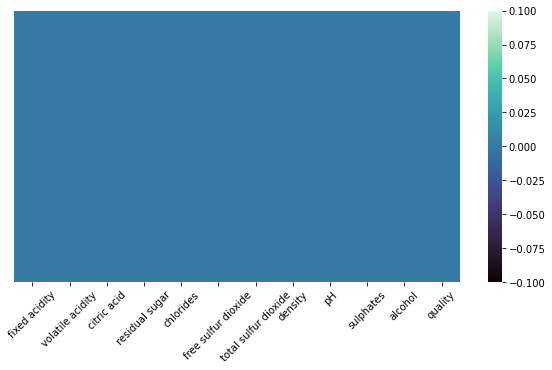

In [9]:
#check for missing values:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=True,cmap='mako')
plt.xticks(rotation=45)
df.isnull().sum()

#### Exploratory data analysis (EDA)

**Count plot of quality variable**

<AxesSubplot:xlabel='quality', ylabel='count'>

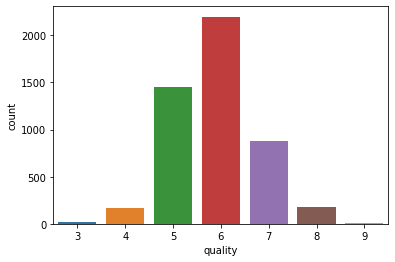

In [8]:
sns.countplot(x='quality',data=df)

**Lets see whether our data has outliers or not:**
- By the below plot: lots of outliers
- However, won't remove them because they are not errors, they are just extreme values

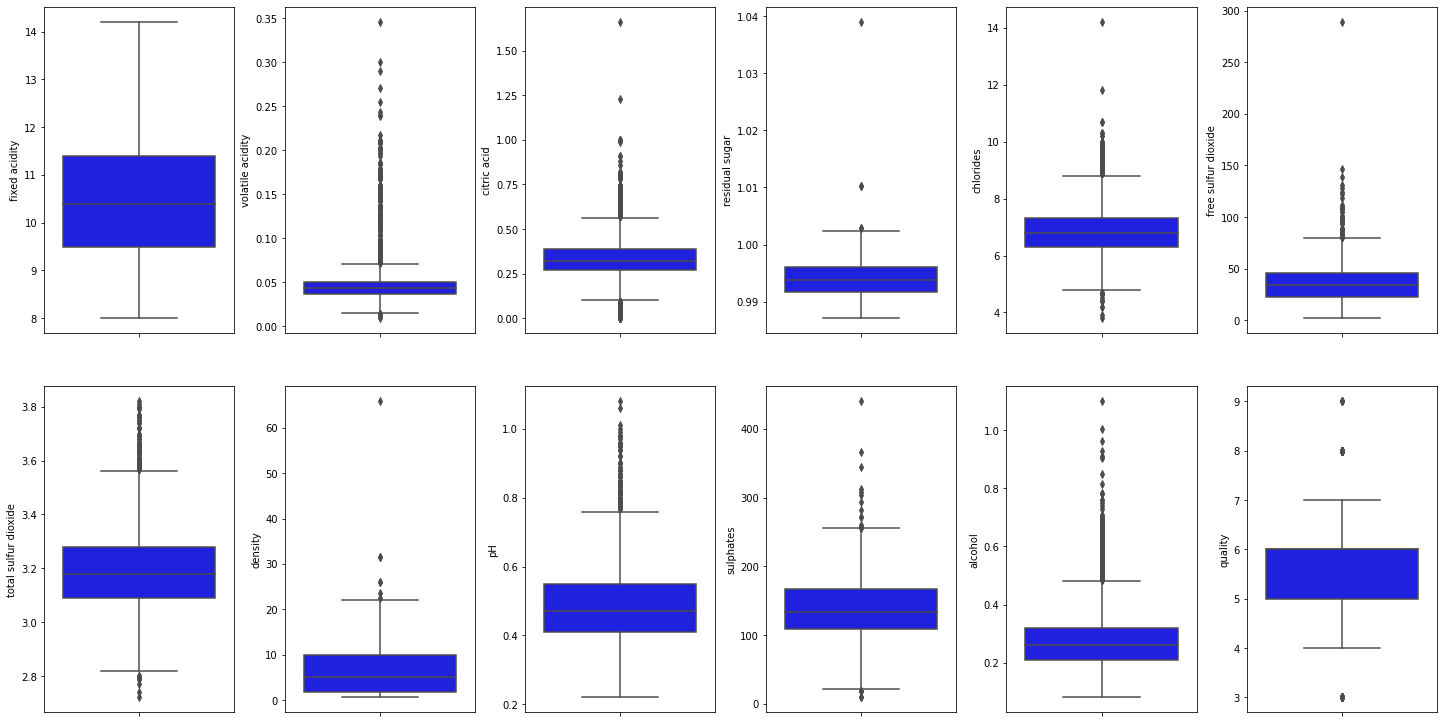

In [12]:
# create box plots
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.boxplot(y=col, data=df, color='b', ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

**Find correlated columns from below figure**
- Wine quality:
    * Positively correlated with the fixed acidity (strongly)
    * Negatively correlated with the residual sugar (strongly)
- Residual sugar:
    * Positively correlated with the density and sulfates (strongly)
- Chlorides: 
    * Negatively correlated with the total sulfur dioxide (strongly)
- Free sulfur dioxide:
    * Positively correlated with the sulphates (strongly)
- Density:
    * Positively correlated with the sulphates (strongly)

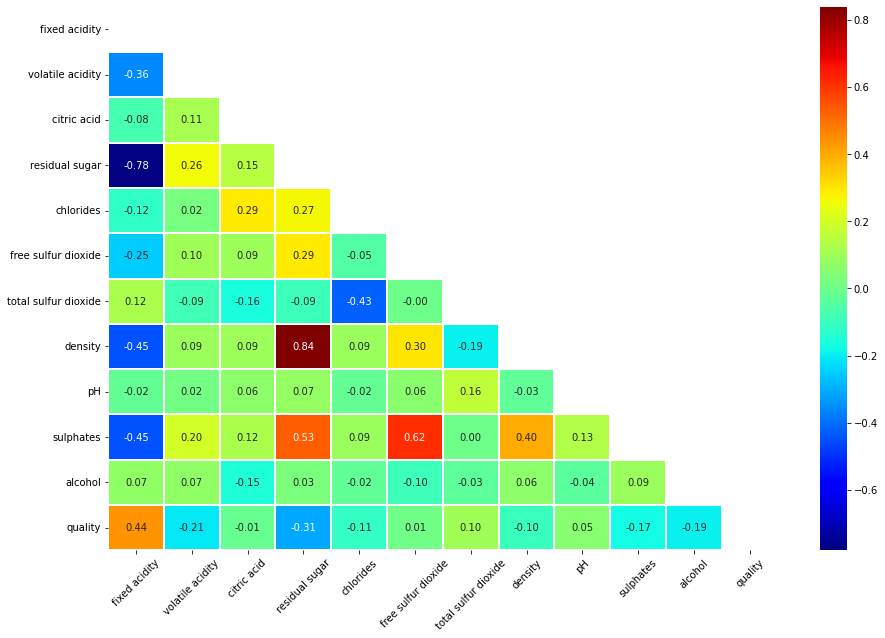

In [25]:
plt.figure(figsize=(15,10))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=2, cmap='jet',mask=mask)
plt.xticks(rotation=45)
plt.show()

**Histogram plot of all features from the below figures**
- Few of them:  normally distributed
- Other: rightly skewed
- The range of each feature: not huge.

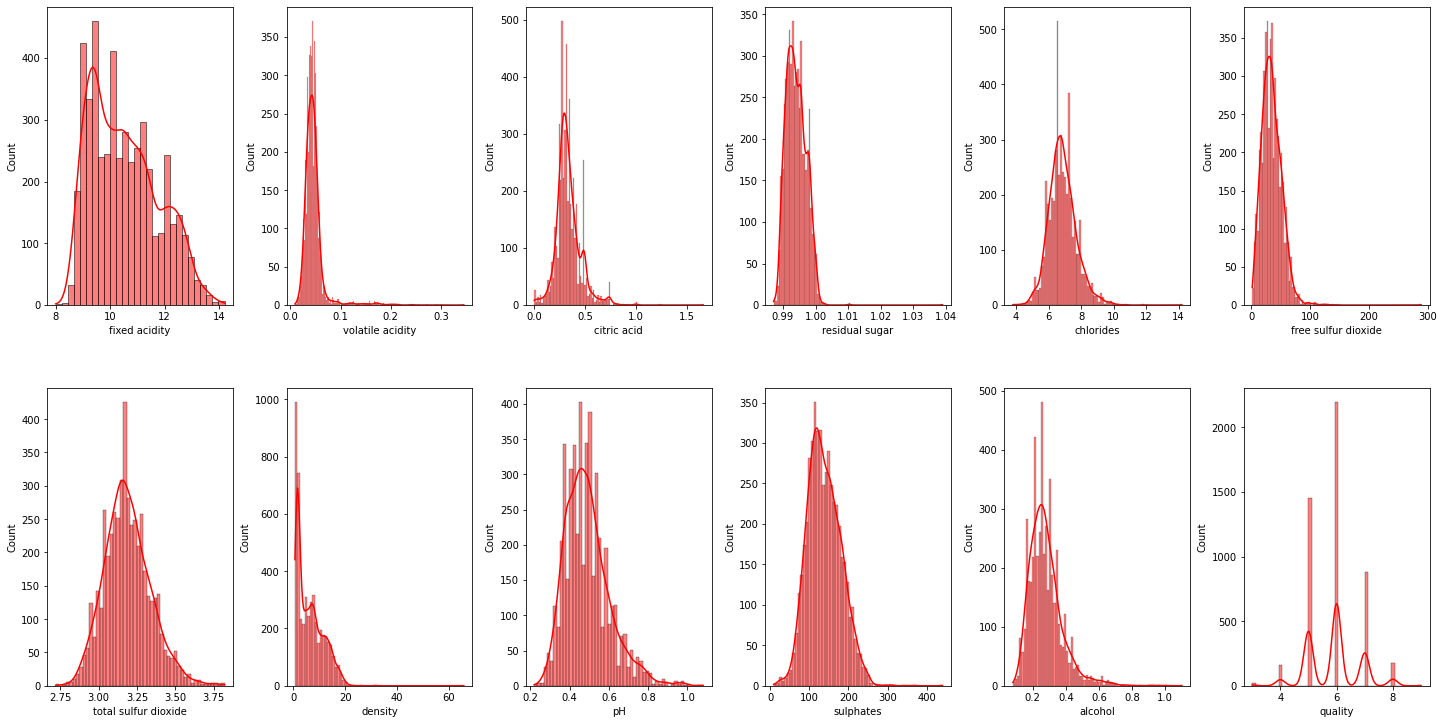

In [31]:
# create hist plot
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.histplot(value, color='r', ax=ax[index],kde = True)
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

**Conclusions after performing EDA**
- Used the Wine Quality dataset provided by UCI to perform EDA
- Discussed how we can perform EDA techniques such as data loading, data wrangling, correlation between variables
- Found that the dataset has outliers and rightly skewed features
- Future works: 
    * Remove outliers
    * Apply feature scaling to the dataset
    * Handle the class imbalance problem
- ***Now, let focus on making a Bayesian neural network model to predict the wine quality score***

## Create training and evaluation datasets
- Construct `get_train_and_test_splits()` function to:
    * Load the `wine_quality` dataset using `tfds.load()`
    * Convert the target feature to float
    * Shuffle the dataset and split it into training and test sets
    * Take the first `train_size` examples as the train split, and the rest as the test split

In [3]:
def get_train_and_test_splits(train_size, batch_size=1):
    # We prefetch with a buffer the same size as the dataset because th dataset
    # is very small and fits into memory.
    dataset = (
        tfds.load(name="wine_quality", as_supervised=True, split="train")
        .map(lambda x, y: (x, tf.cast(y, tf.float32)))
        .prefetch(buffer_size=dataset_size)
        .cache()
    )
    # We shuffle with a buffer the same size as the dataset.
    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset

## Compile, train, and evaluate the model
- NN architecture: 2 layers with 8 units each (can be tuned)
- Learning rate: 0.001 (can be tuned)
- Construct `run_experiment()` function to:
    * Compile the model: `model.comnpile()`
    * Train the model: `model.fit()`
    * Evaluate the model on the train and test sets: `model.evaluate()`

In [4]:
hidden_units = [8, 8] # 2 layers with 8 units each
learning_rate = 0.001


def run_experiment(model, loss, train_dataset, test_dataset):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")


## Create model inputs (i.e., name the inputs)

In [5]:
FEATURE_NAMES = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]


def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs


## Experiment 1: standard neural network
- Construct `create_baseline_model()` function to create a standard deterministic neural network

In [6]:
def create_baseline_model():
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

- Split the wine dataset into training and test sets, with 85% and 15% of the examples, respectively

In [7]:
dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.85)
train_dataset, test_dataset = get_train_and_test_splits(train_size, batch_size)

- Let's train the baseline model: 
    * `.save_weights()`: save the weights of the model
    * `.load_weights()`: load the weights of the model
- Use the `MeanSquaredError` as the loss function

In [8]:
num_epochs = 100
mse_loss = keras.losses.MeanSquaredError()
baseline_model = create_baseline_model()
if os.path.exists('pretrained_model/baseline_model.h5'):
    print("Model exists, load weights")
    baseline_model.load_weights('pretrained_model/baseline_model.h5')
else:
    print("Model not exists, train model")
    run_experiment(baseline_model, mse_loss, train_dataset, test_dataset)
    baseline_model.save_weights('pretrained_model/baseline_model.h5')

- Let's take a sample from the test set use the model to obtain predictions for them
- Baseline model: deterministic
    * A single a *point estimate* prediction for each test example
    * No information about the uncertainty of the model nor the prediction

In [53]:
sample = 50
examples, targets = list(test_dataset.unbatch().shuffle(batch_size * 10).batch(sample))[0]
predicted = baseline_model(examples).numpy()

for idx in range(sample):
    if idx == 10:
        break
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {targets[idx]}")

Predicted: 6.3 - Actual: 7.0
Predicted: 5.8 - Actual: 5.0
Predicted: 5.2 - Actual: 6.0
Predicted: 5.5 - Actual: 5.0
Predicted: 5.9 - Actual: 6.0
Predicted: 5.8 - Actual: 6.0
Predicted: 5.5 - Actual: 5.0
Predicted: 5.3 - Actual: 5.0
Predicted: 5.5 - Actual: 5.0
Predicted: 5.5 - Actual: 5.0


- Visualize the correlation between the predicted and actual wine quality scores

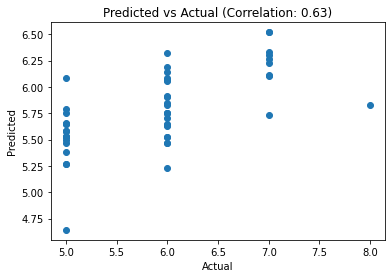

In [54]:
# Convert y_true to numpy array
y_true = np.asarray(targets.numpy()).reshape(-1)
y_pred = predicted.reshape(-1)
# Calculate correlation coefficient
corr_coef = np.corrcoef(y_pred , y_true)[0, 1]

# Plot the predicted vs actual values
plt.scatter(y_true, y_pred)
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title(f"Predicted vs Actual (Correlation: {corr_coef:.2f})")
plt.show()

## Experiment 2: Bayesian neural network (BNN)

The object of the Bayesian approach:
-  Capture the *epistemic uncertainty*, which is uncertainty about the model fitness, due to limited training data

Main idea:
-  Instead of learning specific weight (and bias) *values* in the neural network, the Bayesian approach learns weight *distributions* from which we can sample to produce an output for a given input to encode weight uncertainty

***Thus, define prior and the posterior distributions of these weights, and the training process is to learn the parameters of these distributions***

In [25]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

- Use the `tfp.layers.DenseVariational` layer instead of the standard `keras.layers.Dense` layer in the neural network model

In [26]:
def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

The epistemic uncertainty:
- Can be reduced as we increase the size of the training data
- The more data the BNN model sees, the more it is certain about its estimates for the weights (distribution parameters)

**Let's test this behaviour by training the BNN model on a small subset of the training set, and then on the full training set, to compare the output variances**

### Train BNN  with a small training subset.

In [55]:
num_epochs = 500
train_sample_size = int(train_size * 0.3)
small_train_dataset = train_dataset.unbatch().take(train_sample_size).batch(batch_size)

bnn_model_small = create_bnn_model(train_sample_size)
if os.path.exists('pretrained_model/bnn_model_full.h5'):
    print("Model exists, load weights")
    bnn_model_small.load_weights('pretrained_model/bnn_model_small.h5')
else:
    print("Model not exists, train model")
    run_experiment(bnn_model_small, mse_loss, train_dataset, test_dataset)
    bnn_model_small.save_weights('pretrained_model/bnn_model_small.h5')

Model exists, load weights


- The trained a BNN model:
    * Produce a different output each time we call it with the same input, since each time a new set of weights are sampled from the distributions to construct the network and produce an output
    * The less certain the mode weights are, the more variability (wider range) we will see in the outputs of the same inputs

In [61]:

def compute_predictions(model, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    for idx in range(sample):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )
    return prediction_mean, prediction_min, prediction_max, prediction_range

predicted_mean, predicted_min,  predicted_max, predicted_range = compute_predictions(bnn_model_small)

Predictions mean: 6.19, min: 5.62, max: 6.51, range: 0.9 - Actual: 7.0
Predictions mean: 6.06, min: 5.4, max: 6.37, range: 0.97 - Actual: 5.0
Predictions mean: 5.45, min: 4.83, max: 6.02, range: 1.19 - Actual: 6.0
Predictions mean: 5.69, min: 4.75, max: 6.21, range: 1.45 - Actual: 5.0
Predictions mean: 6.05, min: 5.59, max: 6.34, range: 0.74 - Actual: 6.0
Predictions mean: 5.92, min: 5.3, max: 6.36, range: 1.06 - Actual: 6.0
Predictions mean: 5.69, min: 4.69, max: 6.24, range: 1.55 - Actual: 5.0
Predictions mean: 5.48, min: 4.82, max: 6.12, range: 1.3 - Actual: 5.0
Predictions mean: 5.4, min: 4.65, max: 5.96, range: 1.31 - Actual: 5.0
Predictions mean: 6.02, min: 5.27, max: 6.44, range: 1.18 - Actual: 5.0
Predictions mean: 6.25, min: 5.81, max: 6.52, range: 0.71 - Actual: 6.0
Predictions mean: 5.32, min: 4.45, max: 5.97, range: 1.52 - Actual: 6.0
Predictions mean: 6.11, min: 5.49, max: 6.44, range: 0.94 - Actual: 6.0
Predictions mean: 5.96, min: 5.35, max: 6.31, range: 0.97 - Actual: 6

- Visualize the correlation between the predicted and actual wine quality scores with uncertainty

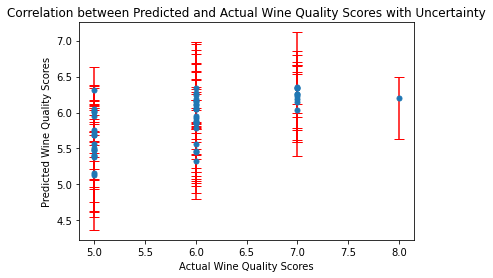

In [62]:
import matplotlib.pyplot as plt

# Calculate the errors
errors = [(predicted_mean[i] - predicted_min[i], predicted_max[i] - predicted_mean[i]) for i in range(len(predicted_mean))]
errors = np.asarray(errors).reshape(2, -1)

# Create the scatter plot with error bars
fig, ax = plt.subplots()
# ax.errorbar(y_true, predicted_mean, yerr=errors, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0)
ax.errorbar(y_true, predicted_mean, yerr=errors, fmt='o',  ecolor='r', markersize=5, capsize=5)
ax.set_ylabel('Predicted Wine Quality Scores')
ax.set_xlabel('Actual Wine Quality Scores')
ax.set_title('Correlation between Predicted and Actual Wine Quality Scores with Uncertainty')
plt.show()

### Train BNN  with the whole training set.

In [58]:
num_epochs = 500
bnn_model_full = create_bnn_model(train_size)
if os.path.exists('pretrained_model/bnn_model_full.h5'):
    print("Model exists, load weights")
    bnn_model_full.load_weights('pretrained_model/bnn_model_full.h5')
else:
    print("Model not exists, train model")
    run_experiment(bnn_model_full, mse_loss, train_dataset, test_dataset)
    bnn_model_full.save_weights('pretrained_model/bnn_model_full.h5')
predicted_mean, predicted_min,  predicted_max, predicted_range = compute_predictions(bnn_model_full)

Model exists, load weights
Predictions mean: 6.24, min: 5.95, max: 6.45, range: 0.5 - Actual: 7.0
Predictions mean: 5.8, min: 5.43, max: 6.15, range: 0.72 - Actual: 5.0
Predictions mean: 5.24, min: 4.92, max: 5.72, range: 0.8 - Actual: 6.0
Predictions mean: 5.71, min: 5.07, max: 6.19, range: 1.12 - Actual: 5.0
Predictions mean: 5.77, min: 5.43, max: 6.04, range: 0.61 - Actual: 6.0
Predictions mean: 5.88, min: 5.6, max: 6.14, range: 0.54 - Actual: 6.0
Predictions mean: 5.65, min: 5.05, max: 6.14, range: 1.09 - Actual: 5.0
Predictions mean: 5.25, min: 4.83, max: 5.68, range: 0.85 - Actual: 5.0
Predictions mean: 5.22, min: 4.9, max: 5.62, range: 0.72 - Actual: 5.0
Predictions mean: 5.95, min: 5.35, max: 6.36, range: 1.02 - Actual: 5.0
Predictions mean: 6.29, min: 5.96, max: 6.52, range: 0.56 - Actual: 6.0
Predictions mean: 5.18, min: 4.8, max: 5.8, range: 1.0 - Actual: 6.0
Predictions mean: 5.89, min: 5.49, max: 6.24, range: 0.75 - Actual: 6.0
Predictions mean: 5.75, min: 5.34, max: 6.04,

Notice that the model trained with the full training dataset shows smaller range
(uncertainty) in the prediction values for the same inputs, compared to the model
trained with a subset of the training dataset.

- Visualize the correlation between the predicted and actual wine quality scores with uncertainty

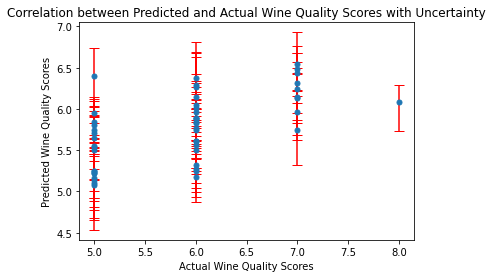

In [60]:
# Calculate the errors
errors = [(predicted_mean[i] - predicted_min[i], predicted_max[i] - predicted_mean[i]) for i in range(len(predicted_mean))]
errors = np.asarray(errors).reshape(2, -1)

# Create the scatter plot with error bars
fig, ax = plt.subplots()
# ax.errorbar(y_true, predicted_mean, yerr=errors, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0)
ax.errorbar(y_true, predicted_mean, yerr=errors, fmt='o',  ecolor='r', markersize=5, capsize=5)
ax.set_ylabel('Predicted Wine Quality Scores')
ax.set_xlabel('Actual Wine Quality Scores')
ax.set_title('Correlation between Predicted and Actual Wine Quality Scores with Uncertainty')
plt.show()

## Experiment 3: probabilistic Bayesian neural network

- So far, the output of the standard and the Bayesian NN models:
    * Deterministic: produces a point estimate as a prediction for a given example

-> To create a probabilistic NN, let's the model output a distribution

-> Captures the *aleatoric uncertainty* as well, which is due to irreducible noise in the data, or to the stochastic nature of the process generating the data

- In this example: 
    * For regression task: model the output as a `IndependentNormal` distribution, with learnable mean and variance parameters.
    * For classification (binary classes): model the output as a `IndependentBernoulli`
    * For classification (multiple classes): model the output as a `OneHotCategorical`

In [63]:
def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

- Use the [negative loglikelihood](https://en.wikipedia.org/wiki/Likelihood_function) as loss function due to the output of the model is a distribution, rather than a point estimate:
    *  Compute how likely to see the true data (targets) from the
estimated distribution produced by the model.

In [64]:

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

num_epochs = 1000
prob_bnn_model = create_probablistic_bnn_model(train_size)
if os.path.exists('pretrained_model/prob_bnn_model.h5'):
    print("Model exists, load weights")
    prob_bnn_model.load_weights('pretrained_model/prob_bnn_model.h5')
else:
    print("Model not exists, train model")
    run_experiment(bnn_model_full, negative_loglikelihood, train_dataset, test_dataset)
    prob_bnn_model.save_weights('pretrained_model/prob_bnn_model.h5')

Model exists, load weights


Now let's produce an output from the model given the test examples.
The output is now a distribution, and we can use its mean and variance
to compute the confidence intervals (CI) of the prediction.

In [80]:
prediction_distribution = prob_bnn_model(examples)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

for idx in range(sample):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(lower[idx][0], 2)} - {round(upper[idx][0], 2)}]"
        f" - Actual: {targets[idx]}"
    )

Prediction mean: 6.3, stddev: 0.82, 95% CI: [4.7 - 7.91] - Actual: 7.0
Prediction mean: 5.99, stddev: 0.75, 95% CI: [4.51 - 7.46] - Actual: 5.0
Prediction mean: 5.08, stddev: 0.68, 95% CI: [3.74 - 6.41] - Actual: 6.0
Prediction mean: 6.11, stddev: 0.76, 95% CI: [4.61 - 7.6] - Actual: 5.0
Prediction mean: 5.59, stddev: 0.72, 95% CI: [4.18 - 7.01] - Actual: 6.0
Prediction mean: 5.91, stddev: 0.76, 95% CI: [4.42 - 7.39] - Actual: 6.0
Prediction mean: 5.84, stddev: 0.74, 95% CI: [4.39 - 7.29] - Actual: 5.0
Prediction mean: 5.21, stddev: 0.69, 95% CI: [3.85 - 6.56] - Actual: 5.0
Prediction mean: 5.1, stddev: 0.68, 95% CI: [3.76 - 6.44] - Actual: 5.0
Prediction mean: 6.02, stddev: 0.77, 95% CI: [4.52 - 7.52] - Actual: 5.0
Prediction mean: 6.38, stddev: 0.81, 95% CI: [4.79 - 7.97] - Actual: 6.0
Prediction mean: 5.09, stddev: 0.68, 95% CI: [3.76 - 6.43] - Actual: 6.0
Prediction mean: 5.73, stddev: 0.74, 95% CI: [4.27 - 7.19] - Actual: 6.0
Prediction mean: 5.57, stddev: 0.73, 95% CI: [4.14 - 7.

- Visualize the correlation between the predicted and actual wine quality scores with uncertainty

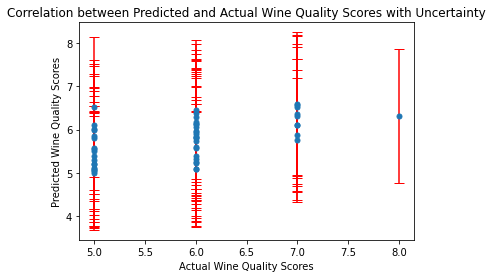

In [81]:
prediction_mean = np.array(prediction_mean).reshape(-1)
# Create the scatter plot with error bars
fig, ax = plt.subplots()
# ax.errorbar(y_true, predicted_mean, yerr=errors, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0)
ax.errorbar(y_true, prediction_mean, yerr=np.array(prediction_stdv).reshape(1, -1) * 1.96, fmt='o',  ecolor='r', markersize=5, capsize=5)
ax.set_ylabel('Predicted Wine Quality Scores')
ax.set_xlabel('Actual Wine Quality Scores')
ax.set_title('Correlation between Predicted and Actual Wine Quality Scores with Uncertainty')
plt.show()